In [3]:
import psycopg2 as pg2
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')

In [50]:
conn = pg2.connect(user='postgres',  dbname='scrabble', host='localhost', port='5432', password='myPassword')
cur = conn.cursor()

sql = """SELECT gamenum, turn_id, movenum, turn_score, rack
from turn where gamenum in (SELECT gamenum from fullP2games) and NOT is_challenge and
gamenum not in (select game_num from bad_games) and
is_player2 = ' 1' and length(rack) = 7 ORDER BY movenum"""


df_good_p2 = pd.read_sql(sql ,con=conn)
df_good_p2 = df_good_p2[df_good_p2.rack.apply(len) <= 7]
df_good_p2.rack = df_good_p2.rack.apply(sorted)
df_good_p2.rack

0         [A, E, F, J, M, P, V]
1         [C, E, G, I, I, N, T]
2         [?, D, E, I, T, T, X]
3         [A, D, L, N, T, W, X]
4         [D, E, F, S, T, U, Y]
                  ...          
179254    [C, D, E, E, I, N, S]
179255    [?, I, O, R, R, U, V]
179256    [E, K, O, O, T, V, X]
179257    [A, B, E, H, O, T, X]
179258    [A, B, E, H, I, T, X]
Name: rack, Length: 179259, dtype: object

In [51]:
class TileCondition:
    def __init__(self, letter, count, compare):
        self._letter = letter
        self._count = count
        self._compare = compare
    def get_lambda(self):
        if (self._compare=="="):
            return lambda x: x.count(self._letter)== self._count
        if (self._compare=="<"):
            return lambda x: x.count(self._letter)== self._count
    def get_label(self):
        if (self._compare=="="):
            return "exactly {:} {:}'s".format(self._count, self._letter)
            

In [52]:




def evaluate(conditions1, conditions2):
    fig, ax = plt.subplots()
    tdf = df_good_p2[df_good_p2.rack.apply(conditions1[0].get_lambda())]
    tdf2 = df_good_p2[df_good_p2.rack.apply(conditions2[0].get_lambda())]
#        print(min(tdf["turn_score"]), max(tdf["turn_score"]))
    if (tdf.shape[0]):
        print("mean score with {:}: {:}, ({:})".format(conditions1[0].get_label(), round(np.mean(tdf["turn_score"]), 2), 
                                                   tdf.shape[0]))
        print("mean score with {:}: {:}, ({:})".format(conditions2[0].get_label(), round(np.mean(tdf2["turn_score"]), 2), 
                                                   tdf2.shape[0]))
        print("p-value: {:}".format(stats.ttest_ind(tdf.turn_score, tdf2.turn_score).pvalue))
#            print(tdf["gamenum"], print(tdf["rack"]))
    ax.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black', label=conditions1[0].get_label())
    ax.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5, label=conditions2[0].get_label())
    ax.legend()
    ax.set_xlim(left=0, right=125)
    print(" ")  


mean score with exactly 1 ?'s: 45.69, (28149)
mean score with exactly 2 ?'s: 58.43, (960)
p-value: 4.3303480259789185e-38
 


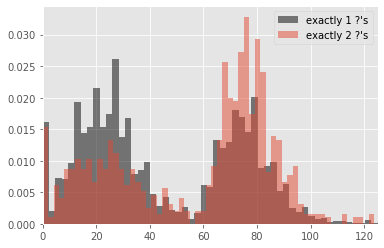

In [46]:
evaluate([TileCondition("?", 1, "=")], [TileCondition("?", 2, "=")])

?
mean score with 0 ?'s: 34.13, (178299)
mean score with at least 1 ?'s: 58.43, (960)
p-value: 1.639526545001652e-232
 


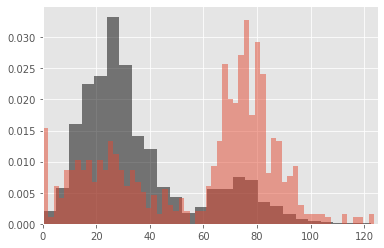

In [6]:
fig, ax = plt.subplots()
letters = ['?', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','?']
for l in letters:
    for i in range(0,1):
        print (l)
        tdf = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)<2)]
        tdf2 = df_good_p2[df_good_p2.rack.apply(lambda x:x.count(l)==2)]
#        print(min(tdf["turn_score"]), max(tdf["turn_score"]))
        if (tdf.shape[0]):
            print("mean score with {:} {:}'s: {:}, ({:})".format(i, l, round(np.mean(tdf["turn_score"]), 2), 
                                                       tdf.shape[0]))
            print("mean score with at least 1 {:}'s: {:}, ({:})".format( l, round(np.mean(tdf2["turn_score"]), 2), 
                                                       tdf2.shape[0])) 
            print("p-value: {:}".format(stats.ttest_ind(tdf.turn_score, tdf2.turn_score).pvalue))
#            print(tdf["gamenum"], print(tdf["rack"]))
        ax.hist(tdf["turn_score"], bins=100, density=True, alpha = .5, color='black')
        ax.hist(tdf2["turn_score"], bins=100, density=True, alpha=.5)
        ax.set_xlim(left=0, right=125)
        print(" ")  
    break;
    print(" ")